data shape after preprocessing (73637, 9)


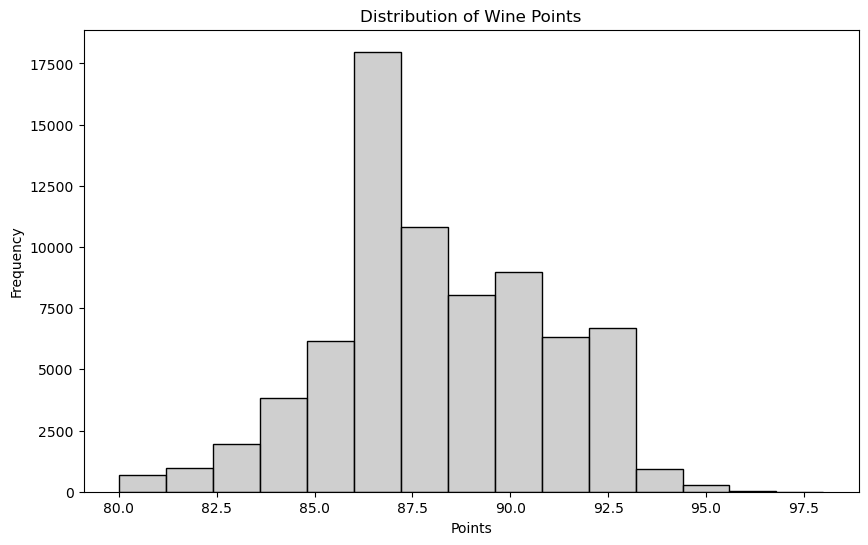

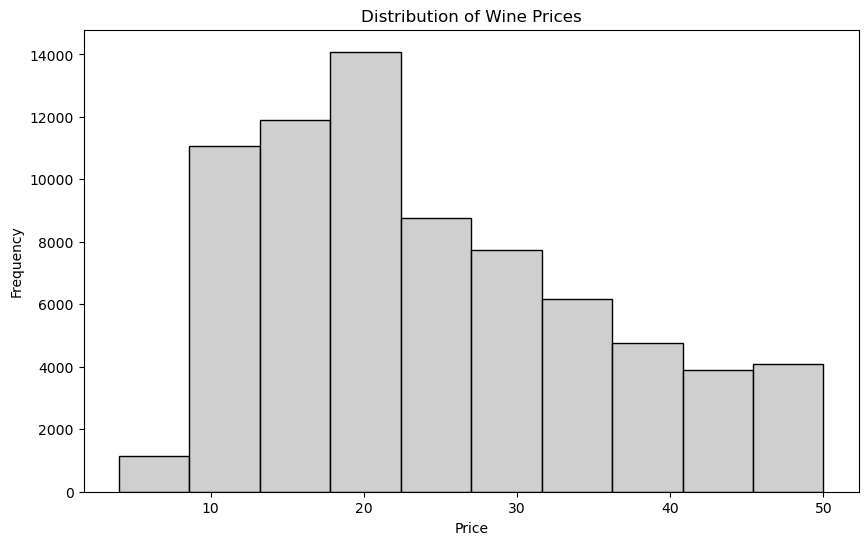

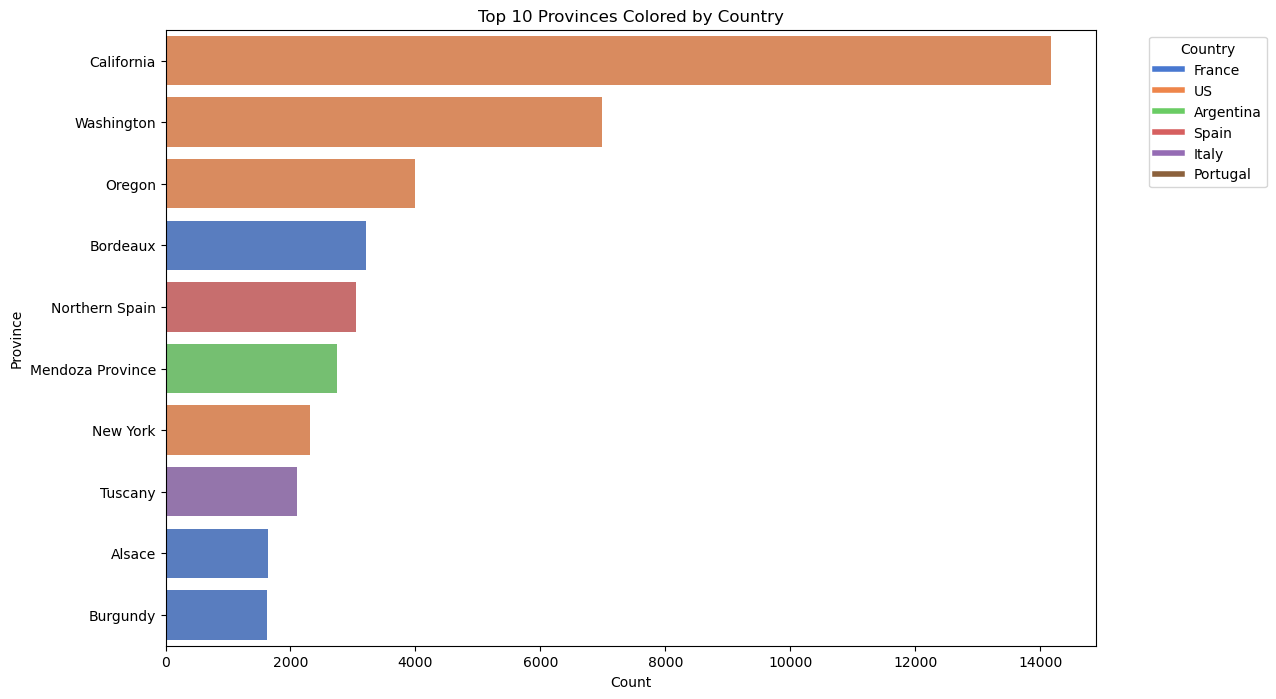

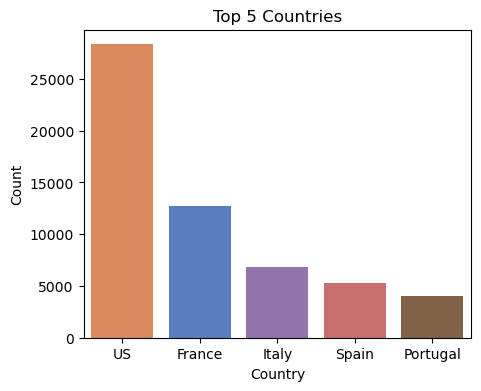

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Load the data
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
save_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/plots_figures/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data.csv')

# Filter out wines with a price > 50
wine_data_low = wine_data.loc[wine_data.price <= 50]
wine_data_low.to_csv(file_path + 'cleaned_wine_data_price_max=50.csv', index=False)
print('data shape after preprocessing', wine_data_low.shape)

# Summary statistics
summary_stats = wine_data_low.describe(include='all')
#print("data summary", summary_stats)

# Distribution of wine points
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['points'], bins=15, color="silver")
plt.title('Distribution of Wine Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.savefig(save_path + 'distribution_wine_points.png', bbox_inches='tight')
plt.show()

# Distribution of wine prices
plt.figure(figsize=(10, 6))
sns.histplot(wine_data_low['price'], bins=10, color="silver")
plt.title('Distribution of Wine Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig(save_path + 'distribution_wine_prices.png', bbox_inches='tight')
plt.show()

# Top 10 provinces colored by Country 
top_provinces = wine_data_low['province'].value_counts().head(10).index
filtered_data = wine_data_low[wine_data_low['province'].isin(top_provinces)]
province_country_map = filtered_data.groupby('province')['country'].first().to_dict()
province_counts = wine_data_low['province'].value_counts().loc[top_provinces]

# Set a color palette for Countries for both plots
top_countries_in_provinces = list(province_country_map.values())
top_countries = wine_data_low['country'].value_counts().head(5).index
unique_countries = pd.unique(top_countries_in_provinces + list(top_countries))
color_palette = sns.color_palette("muted", len(unique_countries))
country_color_map = dict(zip(unique_countries, color_palette))

# Apply the color mapping to the provinces
province_colors = [country_color_map[province_country_map[province]] for province in province_counts.index]
plt.figure(figsize=(12, 8))
sns.barplot(y=province_counts.index, x=province_counts.values, palette=province_colors)
plt.title('Top 10 Provinces Colored by Country')
plt.xlabel('Count')
plt.ylabel('Province')

# Create a custom legend
handles = [plt.Line2D([0], [0], color=country_color_map[country], lw=4) for country in unique_countries]
plt.legend(handles, unique_countries, title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(save_path + 'top_provinces_by_country.png', bbox_inches='tight')
plt.show()

# Plotting the top 5 countries with matching colors
plt.figure(figsize=(5, 4))
sns.barplot(x=top_countries, y=wine_data_low['country'].value_counts().loc[top_countries], 
            palette=[country_color_map[country] for country in top_countries])
plt.title('Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.savefig(save_path + 'top_5_countries.png', bbox_inches='tight')
plt.show()


In [18]:
from collections import Counter
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Load the data
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50.csv')

# List of multi-word expressions (MWEs) to keep together
multi_word_expressions = [
    'red fruit', 'black fruit', 'tropical fruit', 'stone fruit', 'citrus fruit', 
    'green apple'
]

# List of specific words to always keep
words_to_keep = [
    'lime', 'lemon', 'orange', 'grapefruit', 'apple', 'berry', 'peach', 'plum', 
    'melon', 'nectarine', 'pineapple', 'mango', 'papaya', 'blackberry', 'raspberry', 
    'cherry', 'blueberry', 'strawberry'
]

# Custom POS dictionary (add more as needed)
custom_pos_dict = {
    'finish': 'NN',
    'touch': 'NN',
    'hint': 'NN',
    'nose': 'NN',
    'juicy': 'JJ',
    'fruity': 'JJ',
    'ripe': 'JJ',
    'crisp': 'JJ',
    'acidity': 'NN',
    'vanilla': 'NN',
    'herb': 'NN',
}

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function to detect and merge MWEs before processing
def detect_and_merge_mwes(description):
    for mwe in multi_word_expressions:
        if (mwe in description):
            description = description.replace(mwe, mwe.replace(" ", "_"))  # Temporarily replace space with underscore
    return description

# Function to process descriptions and count adjectives and nouns
def process_description(description):
    # Handle MWEs first
    description = detect_and_merge_mwes(description.lower())
    
    # Tokenize and remove stopwords
    words = word_tokenize(description)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalpha() or "_" in word]  # Allow MWEs to pass through
    
    # POS tagging with custom dictionary override
    pos_tags = [(word, custom_pos_dict.get(word, pos)) for word, pos in pos_tag(filtered_words)]
    
    processed_words = []
    num_adjectives = 0
    num_nouns = 0

    for word, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos)
        
        # Count adjectives and nouns
        if pos.startswith('JJ'):
            num_adjectives += 1
        elif pos.startswith('NN'):
            num_nouns += 1
        
        # Handle MWEs (keep them together) and lemmatize nouns
        if "_" in word:
            processed_words.append(word)  # Keep underscore to avoid splitting
        else:
            if wordnet_pos == wordnet.NOUN:
                word = lemmatizer.lemmatize(word, pos=wordnet_pos)
            # Ensure words to keep are added even if they are not adjectives/nouns
            if (pos in ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']) or word in words_to_keep:
                processed_words.append(word)
    
    # Remove specific unwanted nouns but keep MWEs and specific words
    exclude_nouns = {'wine', 'aroma', 'flavor', 'note', 'drink'}
    processed_words = [word for word in processed_words if word not in exclude_nouns or word in words_to_keep or "_" in word]
    
    # Convert underscores back to spaces for the final output
    processed_words = [word.replace("_", " ") for word in processed_words]
    
    # Return the processed description, number of adjectives, and number of nouns
    return ' '.join(processed_words), num_adjectives, num_nouns

# Apply processing to each description and create new columns
wine_data_low[['processed_description', 'num_adjectives', 'num_nouns']] = wine_data_low['description'].dropna().apply(lambda x: pd.Series(process_description(x)))

# Extract all processed words for frequency counting
all_processed_words = ' '.join(wine_data_low['processed_description']).split()

# Count frequencies of the unique adjectives and nouns
pos_tags = pos_tag(all_processed_words)
nouns = [word for word, pos in pos_tags if custom_pos_dict.get(word, pos).startswith('NN')]
adjectives = [word for word, pos in pos_tags if custom_pos_dict.get(word, pos).startswith('JJ')]

# Get the top 20 most common nouns and adjectives
noun_freq = Counter(nouns).most_common(20)
adj_freq = Counter(adjectives).most_common(20)

# Create DataFrames for plotting
noun_freq_df = pd.DataFrame(noun_freq, columns=['Word', 'Frequency'])
adj_freq_df = pd.DataFrame(adj_freq, columns=['Word', 'Frequency'])

# Plotting the top 20 most common nouns
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=noun_freq_df)
plt.title('Top 20 Most Common Nouns in Wine Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plotting the top 20 most common adjectives
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=adj_freq_df)
plt.title('Top 20 Most Common Adjectives in Wine Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Generate a word cloud for a more visual representation of both nouns and adjectives
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(' '.join(all_processed_words))
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Adjectives and Nouns in Wine Descriptions')
plt.show()

# Save the processed dataset with new columns
wine_data_low.to_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv', index=False)


NameError: name 'wine_data_low' is not defined

In [ ]:
# Initialize a dictionary to store MWE frequencies
mwe_frequencies = {mwe: 0 for mwe in multi_word_expressions}

# Count MWEs in the processed descriptions
for description in wine_data_low['processed_description']:
    for mwe in multi_word_expressions:
        mwe_with_underscore = mwe.replace(" ", "_")
        count = description.count(mwe_with_underscore.replace("_", " "))
        mwe_frequencies[mwe] += count

# Display the frequencies of each MWE
mwe_frequencies_df = pd.DataFrame(list(mwe_frequencies.items()), columns=['MWE', 'Frequency'])
mwe_frequencies_df.sort_values(by='Frequency', ascending=False, inplace=True)

# Display the DataFrame
print(mwe_frequencies_df)

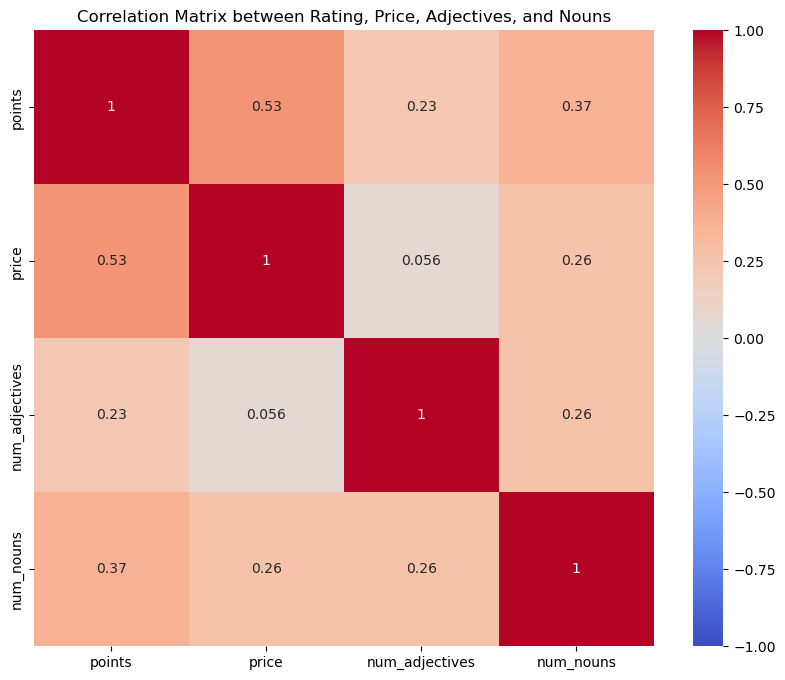

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


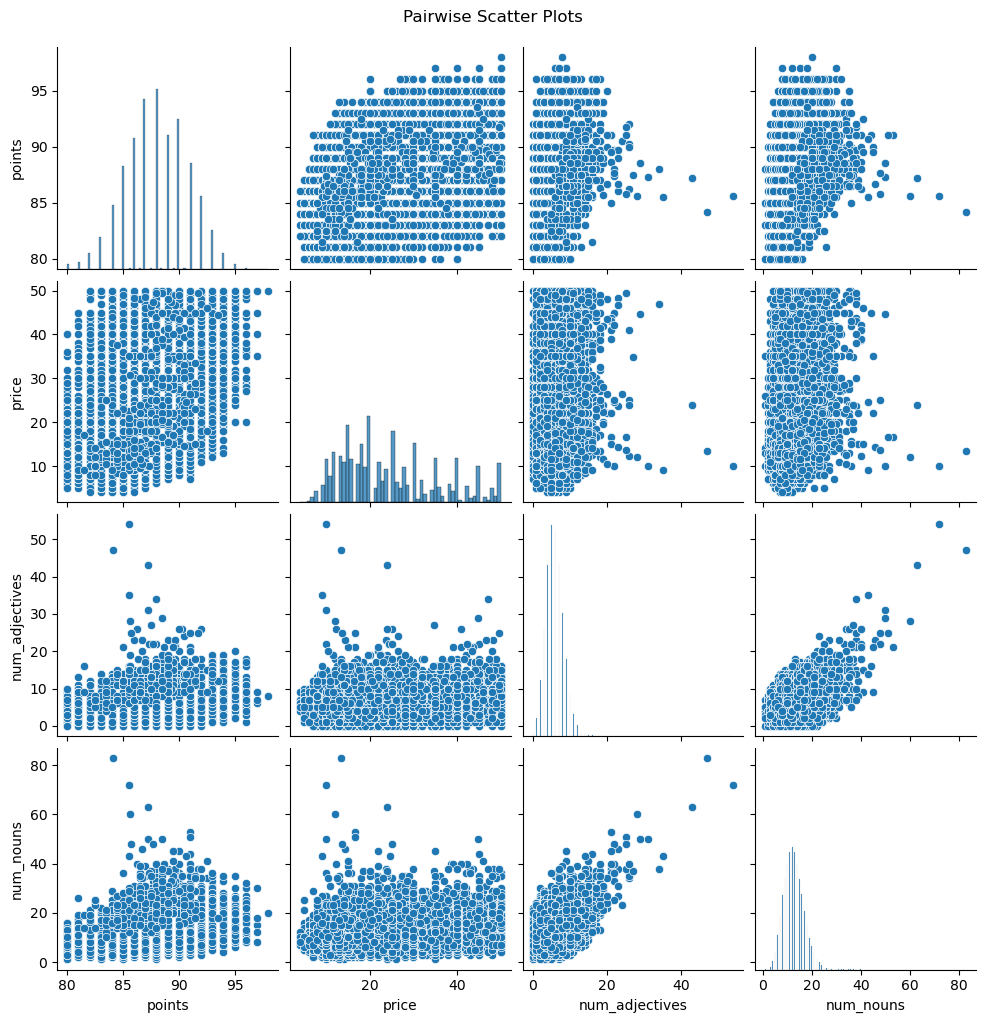

Multiple Linear Regression - Rating as Dependent Variable
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                 1.368e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:54:18   Log-Likelihood:            -1.6271e+05
No. Observations:               73637   AIC:                         3.254e+05
Df Residuals:                   73633   BIC:                         3.255e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

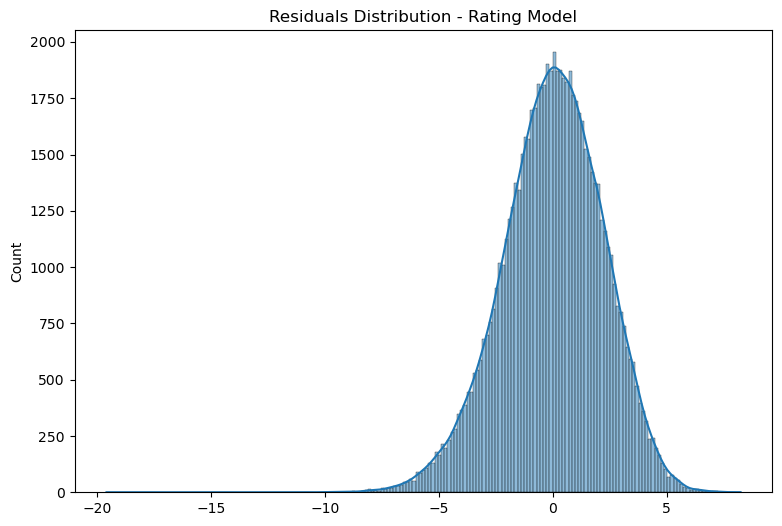

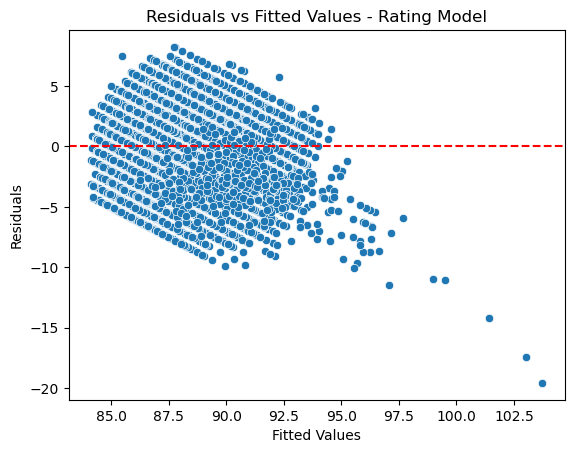

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the processed dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data_low = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# 1. Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = wine_data_low[['points', 'price', 'num_adjectives', 'num_nouns']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Rating, Price, Adjectives, and Nouns')
plt.show()

# 2. Pairwise Scatter Plots
sns.pairplot(wine_data_low[['points', 'price', 'num_adjectives', 'num_nouns']])
plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.show()

# 3. Multiple Linear Regression - Rating as dependent variable
X = wine_data_low[['price', 'num_adjectives', 'num_nouns']]
y = wine_data_low['points']

# Adding a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model_rating = sm.OLS(y, X).fit()

# Print out the summary
print("Multiple Linear Regression - Rating as Dependent Variable")
print(model_rating.summary())

# 4. Multiple Linear Regression - Price as dependent variable
X_price = wine_data_low[['points', 'num_adjectives', 'num_nouns']]
y_price = wine_data_low['price']

# Adding a constant for the intercept
X_price = sm.add_constant(X_price)

# Fit the model
model_price = sm.OLS(y_price, X_price).fit()

# Print out the summary
print("\nMultiple Linear Regression - Price as Dependent Variable")
print(model_price.summary())

# 5. Interaction Terms
wine_data_low['price_adj_interaction'] = wine_data_low['price'] * wine_data_low['num_adjectives']
wine_data_low['price_noun_interaction'] = wine_data_low['price'] * wine_data_low['num_nouns']

X_interactions = wine_data_low[['price', 'num_adjectives', 'num_nouns', 'price_adj_interaction', 'price_noun_interaction']]
y_interactions = wine_data_low['points']

# Adding a constant for the intercept
X_interactions = sm.add_constant(X_interactions)

# Fit the model with interaction terms
model_interactions = sm.OLS(y_interactions, X_interactions).fit()

# Print out the summary
print("\nMultiple Linear Regression with Interaction Terms - Rating as Dependent Variable")
print(model_interactions.summary())

# 6. Residual Analysis
residuals = model_rating.resid
plt.figure(figsize=(9, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution - Rating Model')
plt.show()

sns.scatterplot(x=model_rating.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values - Rating Model')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Model Summary:
                             OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 1.221e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:51:00   Log-Likelihood:            -1.2575e+05
No. Observations:               57652   AIC:                         2.515e+05
Df Residuals:                   57648   BIC:                         2.515e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              81.7651

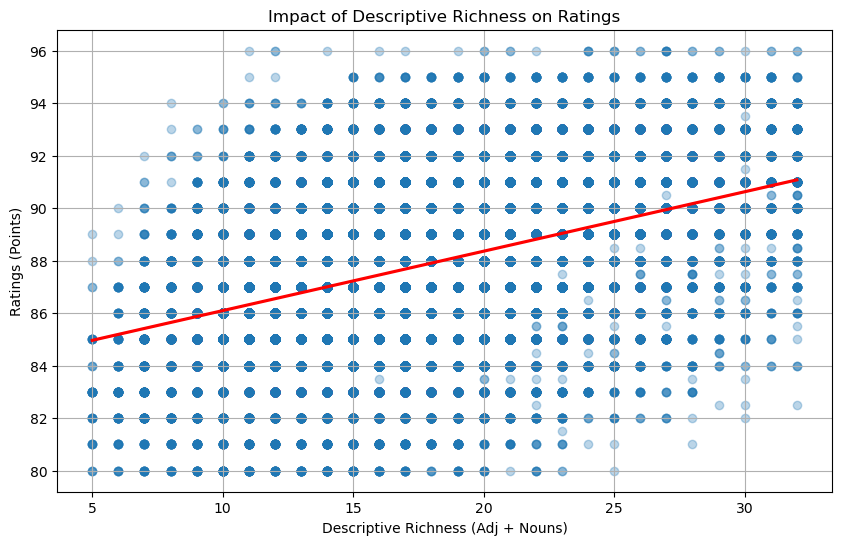

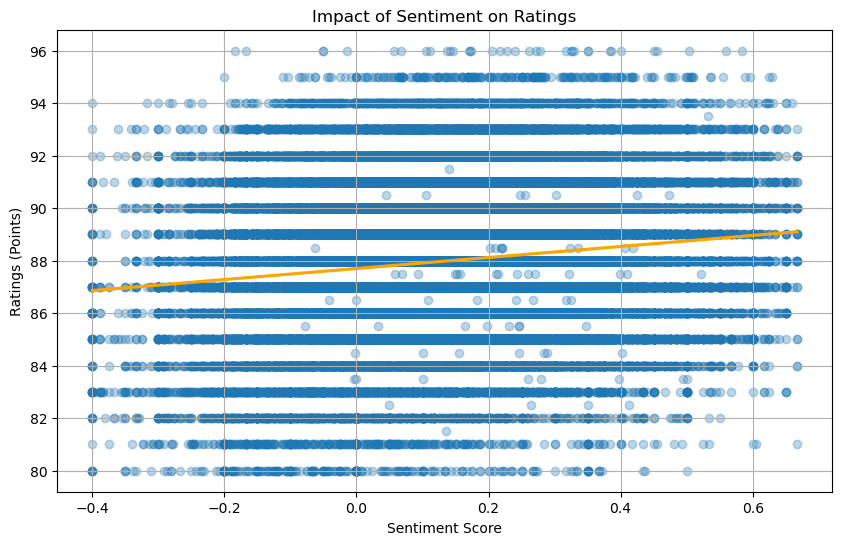

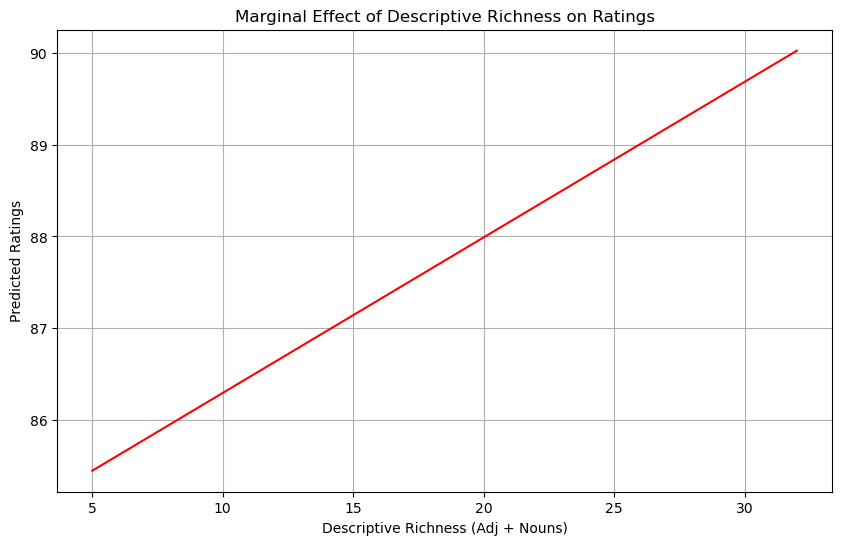

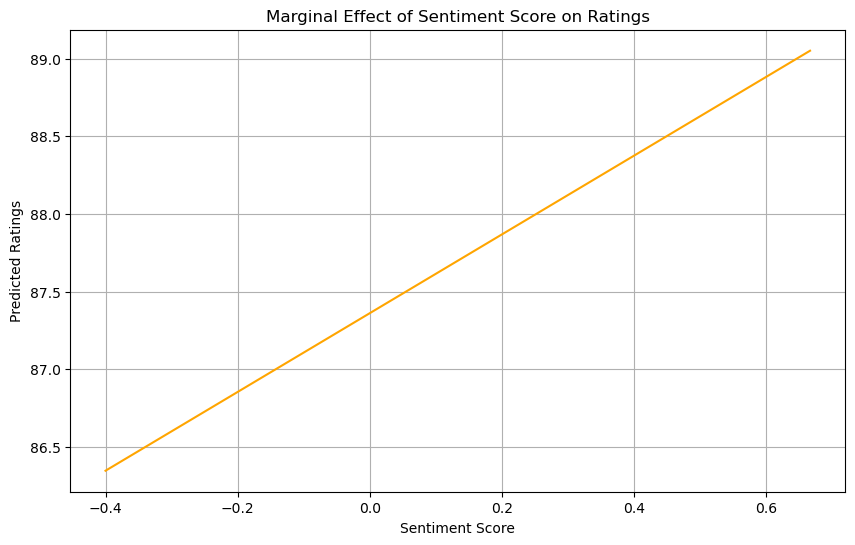

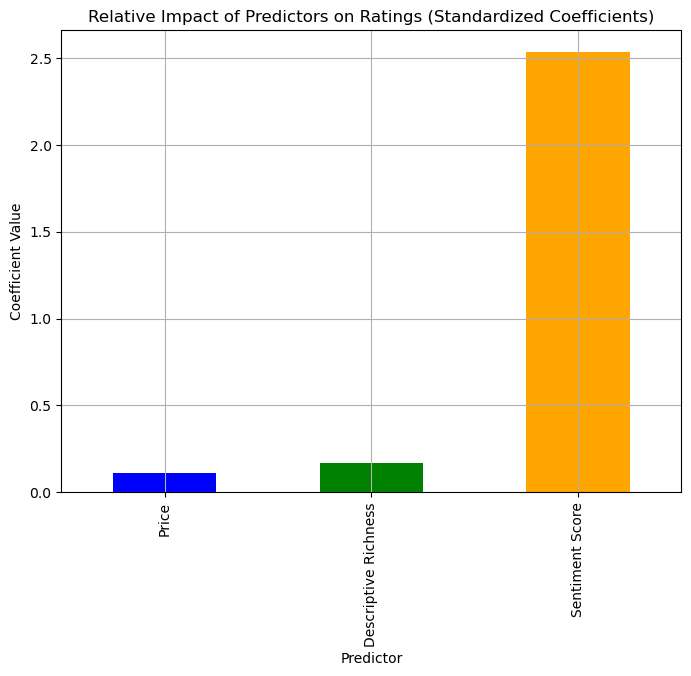

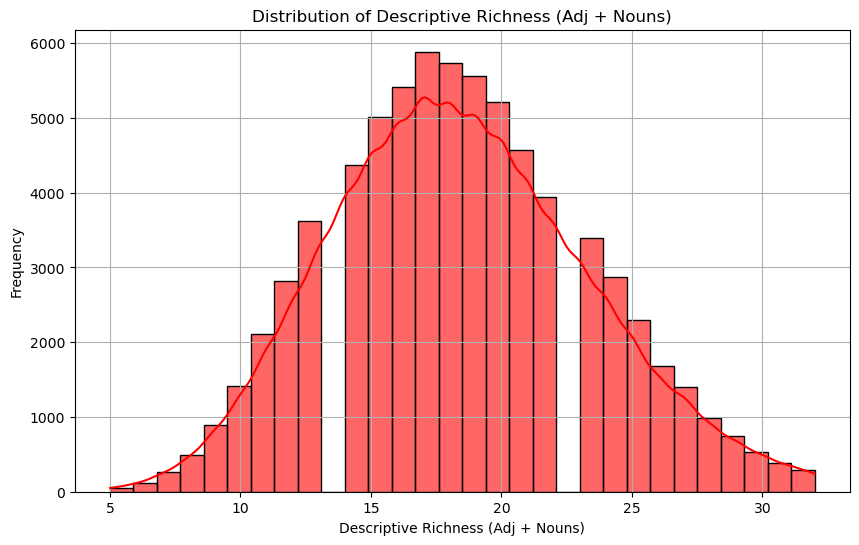

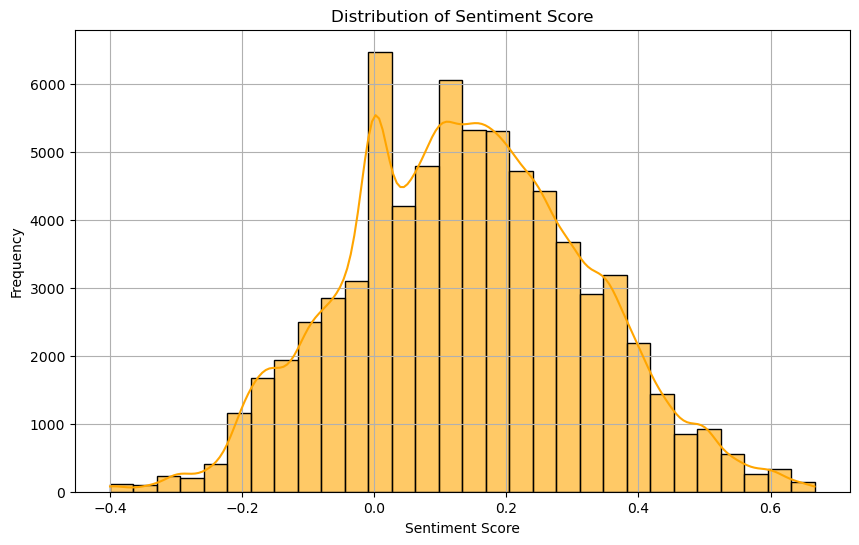

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from textblob import TextBlob

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Compute adj_noun_sum as the sum of num_adjectives and num_nouns
wine_data['adj_noun_sum'] = wine_data['num_adjectives'] + wine_data['num_nouns']

# Compute sentiment score for each wine description using TextBlob
wine_data['sentiment_score'] = wine_data['processed_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

# Remove outliers from the data
columns_to_check = ['price', 'points', 'adj_noun_sum', 'sentiment_score']
cleaned_wine_data = remove_outliers(wine_data, columns_to_check)

# Prepare the dataset for regression analysis
X = cleaned_wine_data[['price', 'adj_noun_sum', 'sentiment_score']]
y = cleaned_wine_data['points']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the multiple linear regression model
model = sm.OLS(y_train, X_train).fit()

# Summary of the model
print("Model Summary:\n", model.summary())

# Calculate VIF to check for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("\nVariance Inflation Factors (VIF):\n", vif_data)

# Finding breakpoints for key predictors vs. ratings
def find_breakpoint(df, x_col, y_col):
    breakpoints = np.linspace(df[x_col].min(), df[x_col].max(), 100)
    best_breakpoint = None
    best_r_squared = -np.inf
    for breakpoint in breakpoints:
        df['x_piecewise'] = np.where(df[x_col] <= breakpoint, df[x_col], breakpoint)
        X_piecewise = df[['x_piecewise']]
        X_piecewise = sm.add_constant(X_piecewise)
        y = df[y_col]
        model_piecewise = sm.OLS(y, X_piecewise).fit()
        if model_piecewise.rsquared > best_r_squared:
            best_r_squared = model_piecewise.rsquared
            best_breakpoint = breakpoint
    return best_breakpoint, best_r_squared

# Finding breakpoints
price_rating_breakpoint, _ = find_breakpoint(cleaned_wine_data, 'price', 'points')
adj_noun_rating_breakpoint, _ = find_breakpoint(cleaned_wine_data, 'adj_noun_sum', 'points')
sentiment_rating_breakpoint, _ = find_breakpoint(cleaned_wine_data, 'sentiment_score', 'points')

# Print the results
print("Best Breakpoint for Price vs. Ratings:", price_rating_breakpoint)
print("Best Breakpoint for Descriptive Richness vs. Ratings:", adj_noun_rating_breakpoint)
print("Best Breakpoint for Sentiment vs. Ratings:", sentiment_rating_breakpoint)

# Create rolling averages for better visualization of trends
cleaned_data_sorted_by_adj_noun_sum = cleaned_wine_data.sort_values(by='adj_noun_sum')
cleaned_data_sorted_by_sentiment = cleaned_wine_data.sort_values(by='sentiment_score')

# Rolling averages
cleaned_adj_noun_sum_roll_mean = cleaned_data_sorted_by_adj_noun_sum['points'].rolling(window=1000).mean()
cleaned_sentiment_roll_mean = cleaned_data_sorted_by_sentiment['points'].rolling(window=1000).mean()

# Scatter Plot with Regression Line for Descriptive Richness vs. Ratings
plt.figure(figsize=(10, 6))
sns.regplot(x='adj_noun_sum', y='points', data=cleaned_wine_data, scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title("Impact of Descriptive Richness on Ratings")
plt.xlabel("Descriptive Richness (Adj + Nouns)")
plt.ylabel("Ratings (Points)")
plt.grid(True)
plt.show()

# Scatter Plot with Regression Line for Sentiment vs. Ratings
plt.figure(figsize=(10, 6))
sns.regplot(x='sentiment_score', y='points', data=cleaned_wine_data, scatter_kws={"alpha": 0.3}, line_kws={"color": "orange"})
plt.title("Impact of Sentiment on Ratings")
plt.xlabel("Sentiment Score")
plt.ylabel("Ratings (Points)")
plt.grid(True)
plt.show()

# Partial Dependence Plots for Descriptive Richness and Sentiment
# Set the median price as a constant for visualization
median_price = cleaned_wine_data['price'].median()
adj_noun_range = np.linspace(cleaned_wine_data['adj_noun_sum'].min(), cleaned_wine_data['adj_noun_sum'].max(), 100)
sentiment_range = np.linspace(cleaned_wine_data['sentiment_score'].min(), cleaned_wine_data['sentiment_score'].max(), 100)

# Partial dependence for adj_noun_sum
adj_noun_df = pd.DataFrame({
    'const': 1,  # Add the constant column
    'price': median_price, 
    'adj_noun_sum': adj_noun_range, 
    'sentiment_score': cleaned_wine_data['sentiment_score'].mean()
})

# Partial dependence for sentiment_score
sentiment_df = pd.DataFrame({
    'const': 1,  # Add the constant column
    'price': median_price, 
    'adj_noun_sum': cleaned_wine_data['adj_noun_sum'].mean(), 
    'sentiment_score': sentiment_range
})

# Predict ratings based on the final model
adj_noun_df['predicted_points'] = model.predict(adj_noun_df)
sentiment_df['predicted_points'] = model.predict(sentiment_df)

# Plot partial dependence for Descriptive Richness
plt.figure(figsize=(10, 6))
plt.plot(adj_noun_df['adj_noun_sum'], adj_noun_df['predicted_points'], color='red')
plt.title("Marginal Effect of Descriptive Richness on Ratings")
plt.xlabel("Descriptive Richness (Adj + Nouns)")
plt.ylabel("Predicted Ratings")
plt.grid(True)
plt.show()

# Plot partial dependence for Sentiment Score
plt.figure(figsize=(10, 6))
plt.plot(sentiment_df['sentiment_score'], sentiment_df['predicted_points'], color='orange')
plt.title("Marginal Effect of Sentiment Score on Ratings")
plt.xlabel("Sentiment Score")
plt.ylabel("Predicted Ratings")
plt.grid(True)
plt.show()

# Standardized Coefficient Impact Bar Plot
coefficients = pd.Series({'Price': 0.1127, 'Descriptive Richness': 0.1695, 'Sentiment Score': 2.5340})
plt.figure(figsize=(8, 6))
coefficients.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title("Relative Impact of Predictors on Ratings (Standardized Coefficients)")
plt.xlabel("Predictor")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.show()

# Distribution Plots for Descriptive Richness and Sentiment
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_wine_data['adj_noun_sum'], bins=30, kde=True, color='red', alpha=0.6)
plt.title("Distribution of Descriptive Richness (Adj + Nouns)")
plt.xlabel("Descriptive Richness (Adj + Nouns)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(cleaned_wine_data['sentiment_score'], bins=30, kde=True, color='orange', alpha=0.6)
plt.title("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Standardized Model Summary:
                             OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.514e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:09:01   Log-Likelihood:            -1.5716e+05
No. Observations:               72065   AIC:                         3.143e+05
Df Residuals:                   72061   BIC:                         3.144e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const        

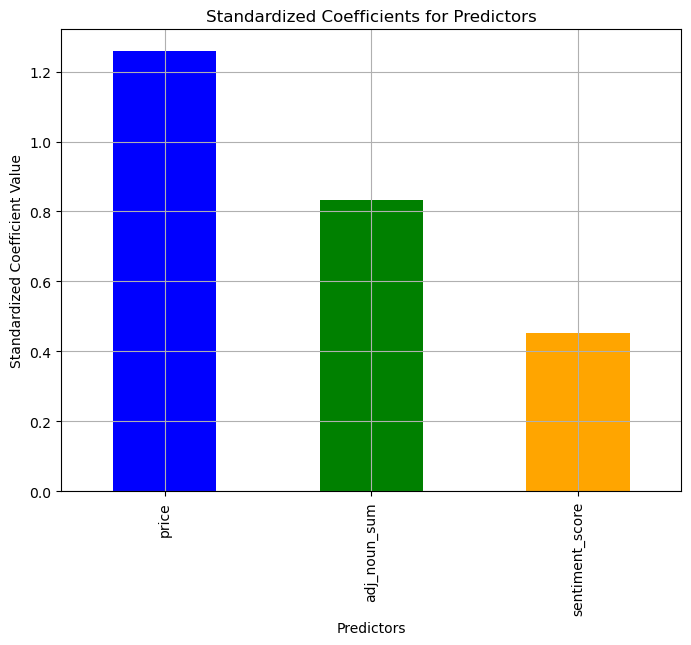


R-squared Values for Different Models:
                           Model  Adjusted R-squared
0                 All Variables            0.386548
1  Without Descriptive Richness            0.298952
2             Without Sentiment            0.359053
3                 Without Price            0.186798


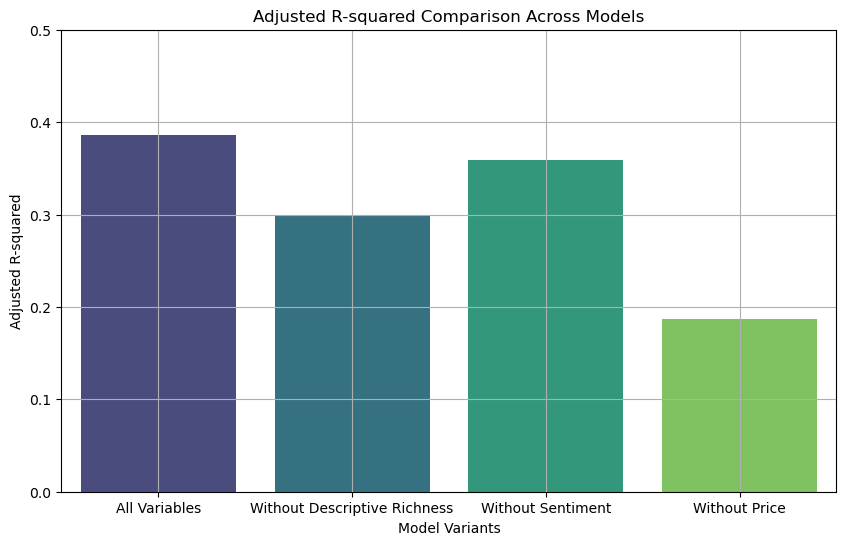

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Compute adj_noun_sum as the sum of num_adjectives and num_nouns
wine_data['adj_noun_sum'] = wine_data['num_adjectives'] + wine_data['num_nouns']

# Compute sentiment score for each wine description using TextBlob
wine_data['sentiment_score'] = wine_data['processed_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

# Remove outliers from the dataset
columns_to_check = ['price', 'points', 'adj_noun_sum', 'sentiment_score']
cleaned_wine_data = remove_outliers(wine_data, columns_to_check)

# Prepare the dataset for regression analysis
X = cleaned_wine_data[['price', 'adj_noun_sum', 'sentiment_score']]
y = cleaned_wine_data['points']

# Reset the indices of X and y to ensure alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Standardize the predictor variables
scaler = StandardScaler()
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add a constant to the standardized data
X_standardized = sm.add_constant(X_standardized)

# Fit the multiple linear regression model using standardized variables
standardized_model = sm.OLS(y, X_standardized).fit()
print("Standardized Model Summary:\n", standardized_model.summary())

# Extract standardized coefficients
standardized_coefficients = standardized_model.params[1:]  # Exclude the intercept (`const`)
print("\nStandardized Coefficients:\n", standardized_coefficients)

# **Plotting Standardized Coefficients**
plt.figure(figsize=(8, 6))
standardized_coefficients.plot(kind='bar', color=['blue', 'green', 'orange'])
plt.title("Standardized Coefficients for Predictors")
plt.xlabel("Predictors")
plt.ylabel("Standardized Coefficient Value")
plt.grid(True)
plt.show()

# **R-squared Analysis**
# Calculate R-squared for different models by dropping variables

# Model with all variables
adj_r_squared_all = standardized_model.rsquared_adj

# Model without Descriptive Richness
model_without_adj_noun = sm.OLS(y, X_standardized.drop(columns=['adj_noun_sum'])).fit()
adj_r_squared_without_adj_noun = model_without_adj_noun.rsquared_adj

# Model without Sentiment
model_without_sentiment = sm.OLS(y, X_standardized.drop(columns=['sentiment_score'])).fit()
adj_r_squared_without_sentiment = model_without_sentiment.rsquared_adj

# Model without Price
model_without_price = sm.OLS(y, X_standardized.drop(columns=['price'])).fit()
adj_r_squared_without_price = model_without_price.rsquared_adj

# Store R-squared values in a DataFrame
r_squared_df = pd.DataFrame({
    'Model': ['All Variables', 'Without Descriptive Richness', 'Without Sentiment', 'Without Price'],
    'Adjusted R-squared': [adj_r_squared_all, adj_r_squared_without_adj_noun, adj_r_squared_without_sentiment, adj_r_squared_without_price]
})

print("\nR-squared Values for Different Models:\n", r_squared_df)

# **Plot R-squared Values**
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Adjusted R-squared', data=r_squared_df, palette='viridis')
plt.title("Adjusted R-squared Comparison Across Models")
plt.xlabel("Model Variants")
plt.ylabel("Adjusted R-squared")
plt.ylim(0, 0.5)  # Set limit to highlight the differences
plt.grid(True)
plt.show()



Model 1: Linear Sentiment Only
                             OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.514e+04
Date:                Tue, 08 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:47:09   Log-Likelihood:            -1.5716e+05
No. Observations:               72065   AIC:                         3.143e+05
Df Residuals:                   72061   BIC:                         3.144e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const    

/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


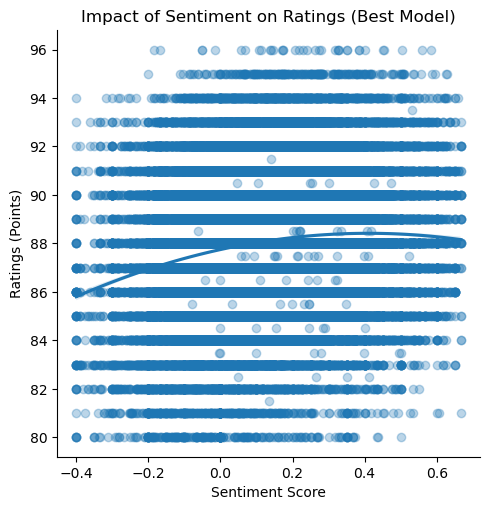

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load the dataset
file_path = '/Users/annelise/Documents/GitHub/Wine_tasting_KG/data_kaggle/'
wine_data = pd.read_csv(file_path + 'cleaned_wine_data_price_max=50_desc=cleaned.csv')

# Compute adj_noun_sum as the sum of num_adjectives and num_nouns
wine_data['adj_noun_sum'] = wine_data['num_adjectives'] + wine_data['num_nouns']

# Compute sentiment score for each wine description using TextBlob
wine_data['sentiment_score'] = wine_data['processed_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Function to remove outliers based on IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]
    return df

# Columns to check for outliers
columns_to_check = ['price', 'points', 'adj_noun_sum', 'sentiment_score']
cleaned_wine_data = remove_outliers(wine_data, columns_to_check)

# Prepare the dataset for regression analysis
X = cleaned_wine_data[['price', 'adj_noun_sum']]
y = cleaned_wine_data['points']

# Create different models to evaluate the impact of linear vs. quadratic sentiment terms
# Model 1: Linear Sentiment Only
X_model1 = cleaned_wine_data[['price', 'adj_noun_sum', 'sentiment_score']]
X_model1 = sm.add_constant(X_model1)  # Add constant term
model1 = sm.OLS(y, X_model1).fit()

# Model 2: Quadratic Sentiment Only
cleaned_wine_data['sentiment_squared'] = cleaned_wine_data['sentiment_score'] ** 2
X_model2 = cleaned_wine_data[['price', 'adj_noun_sum', 'sentiment_score', 'sentiment_squared']]
X_model2 = sm.add_constant(X_model2)  # Add constant term
model2 = sm.OLS(y, X_model2).fit()

# Model 3: No Sentiment Terms
X_model3 = cleaned_wine_data[['price', 'adj_noun_sum']]
X_model3 = sm.add_constant(X_model3)  # Add constant term
model3 = sm.OLS(y, X_model3).fit()

# Display model summaries for comparison
print("\nModel 1: Linear Sentiment Only\n", model1.summary())
print("\nModel 2: Quadratic Sentiment\n", model2.summary())
print("\nModel 3: No Sentiment Terms\n", model3.summary())

# Compare AIC, BIC, and R-squared values for model selection
print("\nComparison of Models:\n")
print(f"Model 1 - Linear Sentiment Only: R-squared = {model1.rsquared:.4f}, AIC = {model1.aic:.2f}, BIC = {model1.bic:.2f}")
print(f"Model 2 - Quadratic Sentiment: R-squared = {model2.rsquared:.4f}, AIC = {model2.aic:.2f}, BIC = {model2.bic:.2f}")
print(f"Model 3 - No Sentiment Terms: R-squared = {model3.rsquared:.4f}, AIC = {model3.aic:.2f}, BIC = {model3.bic:.2f}")

# Determine the best model based on AIC/BIC
best_model = min([(model1, model1.aic, model1.bic), 
                  (model2, model2.aic, model2.bic), 
                  (model3, model3.aic, model3.bic)], key=lambda x: (x[1], x[2]))

print("\nSelected Best Model Based on AIC and BIC:\n", best_model[0].summary())

# Visualize sentiment effects in the best model if sentiment is included
if 'sentiment_score' in best_model[0].params.index:
    sns.lmplot(x='sentiment_score', y='points', data=cleaned_wine_data, order=2 if 'sentiment_squared' in best_model[0].params.index else 1, scatter_kws={"alpha": 0.3})
    plt.title("Impact of Sentiment on Ratings (Best Model)")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Ratings (Points)")
    plt.show()
else:
    print("\nSentiment was not included in the best model.")
